In [1]:
!pip install seaborn

You should consider upgrading via the '/Users/takuro-n/Library/Caches/pypoetry/virtualenvs/debias-bert-3oysVnM2-py3.8/bin/python -m pip install --upgrade pip' command.


In [74]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datasets import load_dataset
from sklearn.metrics import confusion_matrix

In [5]:
GLUE_TASKS = ['CoLA', 'MNLI', 'MRPC', 'QNLI', 'QQP', 'RTE', 'SST-2', 'STS-B', 'WNLI']
MODELS = ['bert-base-uncased', 'less_loss_lr_2e-5_kl_div-epoch-15_no_warmup']

In [6]:
target_path = Path('runs') / 'glue' / 'lr_4e-5_batch_32_epoch_3.0'

In [7]:
for task in GLUE_TASKS:
    print(f'{task}:')
    for model in MODELS:
        task_txt = target_path / task / model / f'eval_results_{task.lower()}.txt'
        if not task_txt.exists():
            continue
        with open(task_txt, 'r') as f:
            print(f'  {model}:')
            for line in f.readlines():
                print(f'\t{line.strip()}')

CoLA:
  bert-base-uncased:
	eval_loss = 0.5004263520240784
	eval_mcc = 0.5625095574827523
  less_loss_lr_2e-5_kl_div-epoch-15_no_warmup:
	eval_loss = 0.5099091529846191
	eval_mcc = 0.5891424967516642
MNLI:
  bert-base-uncased:
	eval_loss = 0.47014543414115906
	eval_mnli/acc = 0.8464595007641366
  less_loss_lr_2e-5_kl_div-epoch-15_no_warmup:
	eval_loss = 0.6451172828674316
	eval_mnli/acc = 0.8379011716760061
MRPC:
  bert-base-uncased:
	eval_loss = 0.44538235664367676
	eval_acc = 0.8161764705882353
	eval_f1 = 0.8752079866888519
	eval_acc_and_f1 = 0.8456922286385435
  less_loss_lr_2e-5_kl_div-epoch-15_no_warmup:
	eval_loss = 0.445195734500885
	eval_acc = 0.8235294117647058
	eval_f1 = 0.8741258741258742
	eval_acc_and_f1 = 0.84882764294529
QNLI:
  bert-base-uncased:
	eval_loss = 0.2770903408527374
	eval_acc = 0.9125022881200805
  less_loss_lr_2e-5_kl_div-epoch-15_no_warmup:
	eval_loss = 0.36783379316329956
	eval_acc = 0.9099395936298736
QQP:
  bert-base-uncased:
	eval_loss = 0.2584780156612

In [18]:
wnli = load_dataset('glue', 'wnli', split='validation')
df_wnli = pd.DataFrame({'sentence1': wnli['sentence1'], 'sentence2': wnli['sentence2'], 'label': wnli['label']})

for model in MODELS:
    task_txt = target_path / 'wnli' / model / f'eval_labels_wnli.txt'
    df_task_results = pd.read_csv(task_txt, sep='\t')
    df_wnli[model] = df_task_results['prediction']

Reusing dataset glue (/Users/takuro-n/.cache/huggingface/datasets/glue/wnli/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


In [89]:
print("True Label: ", len(df_wnli[df_wnli["label"] == 1]))
print("False Label: ", len(df_wnli[df_wnli["label"] == 0]))
print("---")
print("Confusion Matrix: bert-base-uncased")
display(confusion_matrix(df_wnli["label"], df_wnli["bert-base-uncased"]))
print("True Label: ", len(df_wnli[df_wnli["bert-base-uncased"] == 1]))
print("False Label: ", len(df_wnli[df_wnli["bert-base-uncased"] == 0]))
print("---")
print("Confusion Matrix: less_loss_lr_2e-5_kl_div-epoch-15_no_warmup")
display(confusion_matrix(df_wnli["label"], df_wnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"]))
print("True Label: ", len(df_wnli[df_wnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 1]))
print("False Label: ", len(df_wnli[df_wnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 0]))

True Label:  31
False Label:  40
---
Confusion Matrix: bert-base-uncased


array([[30, 10],
       [29,  2]])

True Label:  12
False Label:  59
---
Confusion Matrix: less_loss_lr_2e-5_kl_div-epoch-15_no_warmup


array([[37,  3],
       [31,  0]])

True Label:  3
False Label:  68


In [19]:
df_wnli[df_wnli["bert-base-uncased"] != df_wnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"]]

,sentence1,sentence2,label,bert-base-uncased,less_loss_lr_2e-5_kl_div-epoch-15_no_warmup
18,Bob collapsed on the sidewalk. Soon he saw Carl coming to help. He was very ill.,Carl was very ill.,0,1,0
22,"George got free tickets to the play, but he gave them to Eric, even though he was particularly eager to see it.",Eric was particularly eager to see it.,0,1,0
26,"Although they ran at about the same speed, Sue beat Sally because she had such a good start.",Sally had such a good start.,0,1,0
29,"George got free tickets to the play, but he gave them to Eric, because he was particularly eager to see it.",Eric was particularly eager to see it.,1,1,0
41,Emma did not pass the ball to Janie although she was open.,She saw that Emma was open.,0,1,0
42,John was doing research in the library when he heard a man humming and whistling. He was very annoying.,John was very annoying.,0,1,0
46,"The cat was lying by the mouse hole waiting for the mouse, but it was too cautious.",The mouse was too cautious.,1,1,0
50,"The cat was lying by the mouse hole waiting for the mouse, but it was too cautious.",The cat was too cautious.,0,1,0
69,"It was a summer afternoon, and the dog was sitting in the middle of the lawn. After a while, it got up and moved to a spot under the tree, because it was hot.",The spot under the tree was hot.,0,1,0


In [31]:
cola = load_dataset('glue', 'cola', split='validation')
df_cola = pd.DataFrame({'sentence': cola['sentence'], 'label': cola['label']})

for model in MODELS:
    task_txt = target_path / 'cola' / model / f'eval_labels_cola.txt'
    df_task_results = pd.read_csv(task_txt, sep='\t')
    df_cola[model] = df_task_results['prediction']

Reusing dataset glue (/Users/takuro-n/.cache/huggingface/datasets/glue/cola/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


In [88]:
print("True Label: ", len(df_cola[df_cola["label"] == 1]))
print("False Label: ", len(df_cola[df_cola["label"] == 0]))
print("---")
print("Confusion Matrix: bert-base-uncased")
display(confusion_matrix(df_cola["label"], df_cola["bert-base-uncased"]))
print("True Label: ", len(df_cola[df_cola["bert-base-uncased"] == 1]))
print("False Label: ", len(df_cola[df_cola["bert-base-uncased"] == 0]))
print("---")
print("Confusion Matrix: less_loss_lr_2e-5_kl_div-epoch-15_no_warmup")
display(confusion_matrix(df_cola["label"], df_cola["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"]))
print("True Label: ", len(df_cola[df_cola["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 1]))
print("False Label: ", len(df_cola[df_cola["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 0]))

True Label:  721
False Label:  322
---
bert-base-uncased Confusion Matrix


array([[178, 144],
       [ 41, 680]])

True Label:  824
False Label:  219
---
less_loss_lr_2e-5_kl_div-epoch-15_no_warmup Confusion Matrix


array([[204, 118],
       [ 58, 663]])

True Label:  781
False Label:  262


In [32]:
df_cola[df_cola["bert-base-uncased"] != df_cola["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"]]

,sentence,label,bert-base-uncased,less_loss_lr_2e-5_kl_div-epoch-15_no_warmup
2,The mechanical doll wriggled itself loose.,1,1,0
6,"I demand that the more John eat, the more he pays.",0,1,0
28,The box contained the ball from the tree.,0,1,0
34,The tank leaked the fluid free.,1,1,0
41,Sue gave to Bill a book.,0,1,0
51,"We wanted to invite someone, but we couldn't decide who to.",0,1,0
57,"I know which book José didn't read for class, and which book Lilly did it for him.",0,1,0
59,"I know which book Mag read, and which book Bob said that you hadn't.",1,1,0
62,Rusty talked about himself only after Mary did talk about him.,1,1,0
63,Fred talked about everything before Rusty did talk about something.,1,1,0


In [33]:
stsb = load_dataset('glue', 'stsb', split='validation')
df_stsb = pd.DataFrame({'sentence1': stsb['sentence1'], 'sentence2': stsb['sentence2'], 'label': stsb['label']})

for model in MODELS:
    task_txt = target_path / 'sts-b' / model / f'eval_labels_sts-b.txt'
    df_task_results = pd.read_csv(task_txt, sep='\t')
    df_stsb[model] = df_task_results['prediction']

Reusing dataset glue (/Users/takuro-n/.cache/huggingface/datasets/glue/stsb/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


In [64]:
df_stsb["orig_model_diff"] = df_stsb["label"] - df_stsb["bert-base-uncased"]
df_stsb["tuned_model_diff"] =  df_stsb["label"] - df_stsb["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"]

(0.0, 5.0)

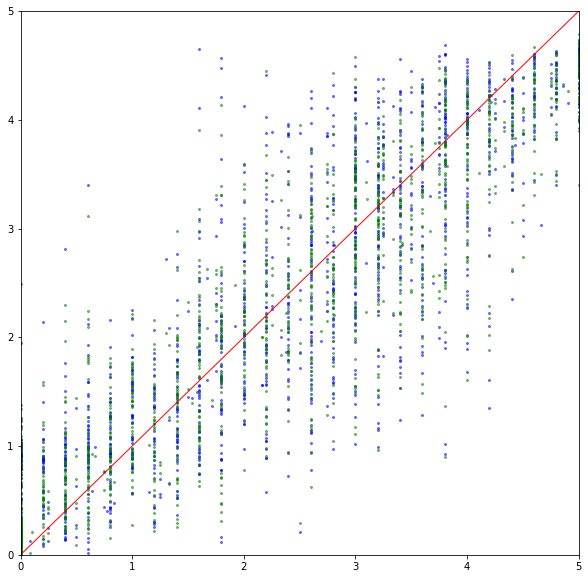

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(df_stsb["label"], df_stsb["bert-base-uncased"], 'bo', markersize=2, alpha=.5)
ax.plot(df_stsb["label"], df_stsb["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"], 'go', markersize=2, alpha=.5)
ax.plot(df_stsb["label"], df_stsb["label"], 'r', linewidth=1)

ax.set_xlim([0, 5.0])
ax.set_ylim([0, 5.0])

(array([ 2.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  2.,  8.,  3.,  4.,  3.,  5.,  1.,  8.,  7.,  4.,
         5., 16., 12., 10., 13., 24., 15., 24., 29., 31., 34., 38., 42.,
        41., 64., 55., 50., 52., 52., 58., 50., 49., 33., 69., 39., 50.,
        38., 39., 43., 39., 40., 30., 26., 21., 20., 22., 16., 15., 20.,
         9., 16.,  8., 10.,  7., 16., 10.,  6.,  7.,  3.,  2.,  2.,  3.,
         5.,  2.,  2.,  2.,  2.,  3.,  0.,  1.,  1.,  2.,  0.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.51899998, -2.46480998, -2.41061998, -2.35642998, -2.30223998,
        -2.24804998, -2.19385998, -2.13966998, -2.08547998, -2.03128998,
        -1.97709998, -1.92290998, -1.86871998, -1.81452999, -1.76033999,
        -1.70614999, -1.65195999, -1.59776999, -1.54357999, -1.48938999,
        -1.43519999, -1.38100999, -1.32681999, -1.27262999, -1.21843999,
        -1.16424999, -1.11005999, -1.05587   , -1.00168   , -0.94749 

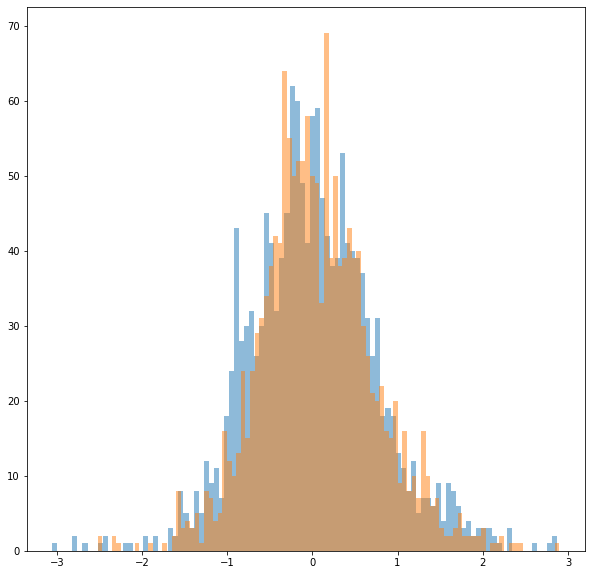

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist(df_stsb["orig_model_diff"], bins=100, alpha=0.5)
ax.hist(df_stsb["tuned_model_diff"], bins=100, alpha=0.5)

In [128]:
mnli = load_dataset('glue', 'mnli', split='validation_matched')
df_mnli = pd.DataFrame({'hypothesis': mnli['hypothesis'], 'premise': mnli['premise'], 'label': mnli['label']})

label_map = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}

for model in MODELS:
    task_txt = target_path / 'mnli' / model / f'eval_labels_mnli.txt'
    df_task_results = pd.read_csv(task_txt, sep='\t')
    df_mnli[model] = df_task_results['prediction']
    df_mnli[model] = df_mnli[model].map(lambda x: label_map[x])

Reusing dataset glue (/Users/takuro-n/.cache/huggingface/datasets/glue/mnli/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


In [132]:
print("Entailment Label: ", len(df_mnli[df_mnli["label"] == 0]))
print("Neutral Label: ", len(df_mnli[df_mnli["label"] == 1]))
print("Contradiction Label: ", len(df_mnli[df_mnli["label"] == 2]))
print("---")
print("Confusion Matrix: bert-base-uncased")
display(confusion_matrix(df_mnli["label"], df_mnli["bert-base-uncased"]))
print("Entailment Label: ", len(df_mnli[df_mnli["bert-base-uncased"] == 0]))
print("Neutral Label: ", len(df_mnli[df_mnli["bert-base-uncased"] == 1]))
print("Contradiction Label: ", len(df_mnli[df_mnli["bert-base-uncased"] == 2]))
print("---")
print("Confusion Matrix: less_loss_lr_2e-5_kl_div-epoch-15_no_warmup")
display(confusion_matrix(df_mnli["label"], df_mnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"]))
print("Entailment Label: ", len(df_mnli[df_mnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 0]))
print("Neutral Label: ", len(df_mnli[df_mnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 1]))
print("Contradiction Label: ", len(df_mnli[df_mnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 2]))

Entailment Label:  3479
Neutral Label:  3123
Contradiction Label:  3213
---
Confusion Matrix: bert-base-uncased


array([[2920,  414,  145],
       [ 206, 2584,  333],
       [ 131,  278, 2804]])

Entailment Label:  3257
Neutral Label:  3276
Contradiction Label:  3282
---
Confusion Matrix: less_loss_lr_2e-5_kl_div-epoch-15_no_warmup


array([[2898,  456,  125],
       [ 218, 2575,  330],
       [ 145,  317, 2751]])

Entailment Label:  3261
Neutral Label:  3348
Contradiction Label:  3206


In [145]:
qnli = load_dataset('glue', 'qnli', split='validation')
df_qnli = pd.DataFrame({'question': qnli['question'], 'sentence': qnli['sentence'], 'label': qnli['label']})

label_map = {
    "entailment": 0,
    "not_entailment": 1,
}

for model in MODELS:
    task_txt = target_path / 'qnli' / model / f'eval_labels_qnli.txt'
    df_task_results = pd.read_csv(task_txt, sep='\t')
    df_qnli[model] = df_task_results['prediction']
    df_qnli[model] = df_qnli[model].map(lambda x: label_map[x])

Reusing dataset glue (/Users/takuro-n/.cache/huggingface/datasets/glue/qnli/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


In [144]:
print("Entailment Label: ", len(df_qnli[df_qnli["label"] == 0]))
print("Not Entailment Label: ", len(df_qnli[df_qnli["label"] == 1]))
print("---")
print("Confusion Matrix: bert-base-uncased")
display(confusion_matrix(df_qnli["label"], df_qnli["bert-base-uncased"]))
print("Entailment Label: ", len(df_qnli[df_qnli["bert-base-uncased"] == 0]))
print("Not Entailment Label: ", len(df_qnli[df_qnli["bert-base-uncased"] == 1]))
print("---")
print("Confusion Matrix: less_loss_lr_2e-5_kl_div-epoch-15_no_warmup")
display(confusion_matrix(df_qnli["label"], df_qnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"]))
print("Entailment Label: ", len(df_qnli[df_qnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 0]))
print("Not Entailment Label: ", len(df_qnli[df_qnli["less_loss_lr_2e-5_kl_div-epoch-15_no_warmup"] == 1]))

Entailment Label:  2702
Not Entailment Label:  2761
---
Confusion Matrix: bert-base-uncased


array([[2479,  223],
       [ 255, 2506]])

Entailment Label:  2734
Not Entailment Label:  2729
---
Confusion Matrix: less_loss_lr_2e-5_kl_div-epoch-15_no_warmup


array([[2487,  215],
       [ 277, 2484]])

Entailment Label:  2764
Not Entailment Label:  2699
